In [9]:
import json

data = json.loads(open('USIS10K\\multi_class_annotations\\multi_class_test_annotations.json').read())

id_to_img = {}

for img in data['images']:
    id_to_img[img['id']] = img['file_name']

def load_data(path='USIS10K\\multi_class_annotations\\multi_class_test_annotations.json'):
    data = json.loads(open(path).read())
    polished_data = []

    for annotation in data['annotations']:
        category_id = annotation['category_id']
        image_id = annotation['image_id']
        bbox = annotation['bbox']
        segmentation = annotation['segmentation']
        img_path = f"USIS10K/test/{id_to_img[image_id]}"

        polished_data.append({
            'img_path': img_path,
            'category_id': category_id,
            'bbox': bbox,
            'segmentation': segmentation
        })

    return polished_data

def load_usis_preds_data(path='usis_sam_preds_rle.json'):
    data = json.loads(open(path).read())
    polished_data = []

    for annotation in data['predictions']:
        category_id = annotation['category_id']
        image_id = annotation['image_id']
        bbox = annotation['bbox']
        segmentation = annotation['segmentation']
        img_path = f"USIS10K/test/{id_to_img[image_id]}"

        polished_data.append({
            'img_path': img_path,
            'category_id': category_id,
            'bbox': bbox,
            'segmentation': segmentation
        })

    return polished_data

In [10]:
PROMPT_TO_CATEGORY = {
    "wrecks/ruins": 1,
    "fish": 2,  
    "reefs": 3,
    "aquatic plants": 4,
    "human divers": 5,
    "robots": 6,
    "sea-floor": 7,
}

CATEGORY_TO_PROMPT = {v: k for k, v in PROMPT_TO_CATEGORY.items()}

In [11]:
# Load ground truth in COCO format for evaluation
gt_data = load_data()
usis_data = load_usis_preds_data()
predictions = json.load(open('sam3_usis10k_preds_rle_simple_prompt.json'))

In [12]:
def convert_usis_to_prediction_format(usis_data):
    """
    Convert USIS predictions from per-annotation format to grouped format matching SAM3 predictions.
    
    Input format (usis_data):
    [
        {'img_path': '...', 'category_id': 1, 'bbox': [x,y,w,h], 'segmentation': {...}},
        {'img_path': '...', 'category_id': 2, 'bbox': [x,y,w,h], 'segmentation': {...}},
        ...
    ]
    
    Output format (matching predictions):
    [
        {
            'img_path': '...',
            'fish': {'boxes': [[x1,y1,x2,y2], ...], 'scores': [...], 'masks_rle': [...]},
            'reefs': {'boxes': [...], 'scores': [...], 'masks_rle': [...]},
            ...
        },
        ...
    ]
    """
    from collections import defaultdict
    
    # Group annotations by image path
    img_annotations = defaultdict(list)
    for ann in usis_data:
        img_annotations[ann['img_path']].append(ann)
    
    # Convert to prediction format
    converted = []
    for img_path, annotations in img_annotations.items():
        pred = {'img_path': img_path}
        
        # Initialize all categories with empty lists
        for prompt in PROMPT_TO_CATEGORY.keys():
            pred[prompt] = {'boxes': [], 'scores': [], 'masks_rle': []}
        
        # Fill in annotations
        for ann in annotations:
            category_id = ann['category_id'] + 1
            prompt_name = CATEGORY_TO_PROMPT.get(category_id, f"unknown_{category_id}")
            
            if prompt_name not in pred:
                pred[prompt_name] = {'boxes': [], 'scores': [], 'masks_rle': []}
            
            # Convert bbox from [x, y, w, h] to [x1, y1, x2, y2]
            x, y, w, h = ann['bbox']
            box_xyxy = [x, y, x + w, y + h]
            pred[prompt_name]['boxes'].append(box_xyxy)
            
            # USIS predictions don't have scores, use 1.0 as default
            pred[prompt_name]['scores'].append(1.0)
            
            # Add segmentation mask (already in RLE format)
            if 'segmentation' in ann and ann['segmentation']:
                pred[prompt_name]['masks_rle'].append(ann['segmentation'])
        
        converted.append(pred)
    
    return converted


def align_predictions_by_image(predictions, usis_predictions):
    """
    Align SAM3 predictions and USIS predictions by image path so they can be compared.
    Returns two lists with matching order based on SAM3 predictions order.
    """
    # Create lookup for USIS predictions by image path
    usis_by_path = {p['img_path']: p for p in usis_predictions}
    
    aligned_usis = []
    for pred in predictions:
        img_path = pred['img_path']
        if img_path in usis_by_path:
            aligned_usis.append(usis_by_path[img_path])
        else:
            # Create empty prediction if not found
            empty_pred = {'img_path': img_path}
            for prompt in PROMPT_TO_CATEGORY.keys():
                empty_pred[prompt] = {'boxes': [], 'scores': [], 'masks_rle': []}
            aligned_usis.append(empty_pred)
    
    return aligned_usis


# Convert USIS data to match prediction format
usis_predictions = convert_usis_to_prediction_format(usis_data)

# Align USIS predictions with SAM3 predictions order
usis_predictions_aligned = align_predictions_by_image(predictions, usis_predictions)

In [13]:
gemini_2_5_flash_bounding_boxes = json.load(open('gemini_2.5_flash.json'))

def convert_detections(input_data):
    """
    Convert detection data from input format to output format.
    
    Args:
        input_data: List of dictionaries with 'file_name' and 'detections'
        
    Returns:
        List of dictionaries with 'img_path' and category-based detections
    """
    
    # Category mapping
    LABEL_TO_CATEGORY = {
        "Fish": "fish",
        "Reefs": "reefs",
        "Aquatic plants": "aquatic plants",
        "Human divers": "human divers",
        "Robots": "robots",
        "Sea-floor": "sea-floor",
        "Wrecks/ruins": "wrecks/ruins"
    }
    
    # All possible categories
    ALL_CATEGORIES = [
        "fish", "wrecks/ruins", "reefs", "aquatic plants", 
        "human divers", "robots", "sea-floor"
    ]
    
    result = []
    
    for item in input_data:
        file_name = item['file_name']
        detections = item['detections']
        
        # Initialize output structure
        output_item = {
            'img_path': f'USIS10K/test/{file_name}.jpg',
        }

        image = Image.open(output_item['img_path'])
        width, height = image.size
        
        # Initialize all categories with empty lists
        for category in ALL_CATEGORIES:
            output_item[category] = {
                'boxes': [],
                'scores': [],
                'masks_rle': []
            }
        
        # Group detections by category
        for detection in detections:
            label = detection['label']
            box_2d = detection['box_2d']

            try:
                abs_y1 = int(box_2d[0]/1000 * height)
                abs_x1 = int(box_2d[1]/1000 * width)
                abs_y2 = int(box_2d[2]/1000 * height)
                abs_x2 = int(box_2d[3]/1000 * width)
                new_bbox = [abs_x1, abs_y1, abs_x2, abs_y2]
            except Exception as e:
                print(f"Error processing box_2d {box_2d} for image {file_name}: {e}")
                new_bbox = [0, 0, 0, 0]
            
            # Get the category name (normalize case)
            category = LABEL_TO_CATEGORY.get(label)
            
            if category:
                # Add box to the appropriate category
                output_item[category]['boxes'].append(new_bbox)
                output_item[category]['scores'].append(1.0)  # Default score
        
        result.append(output_item)
    
    return result

gemini_2_5_flash_converted = convert_detections(gemini_2_5_flash_bounding_boxes)


Error processing box_2d [180, 480, 680] for image test_01506: list index out of range
Error processing box_2d [550, 570, 750] for image test_01506: list index out of range


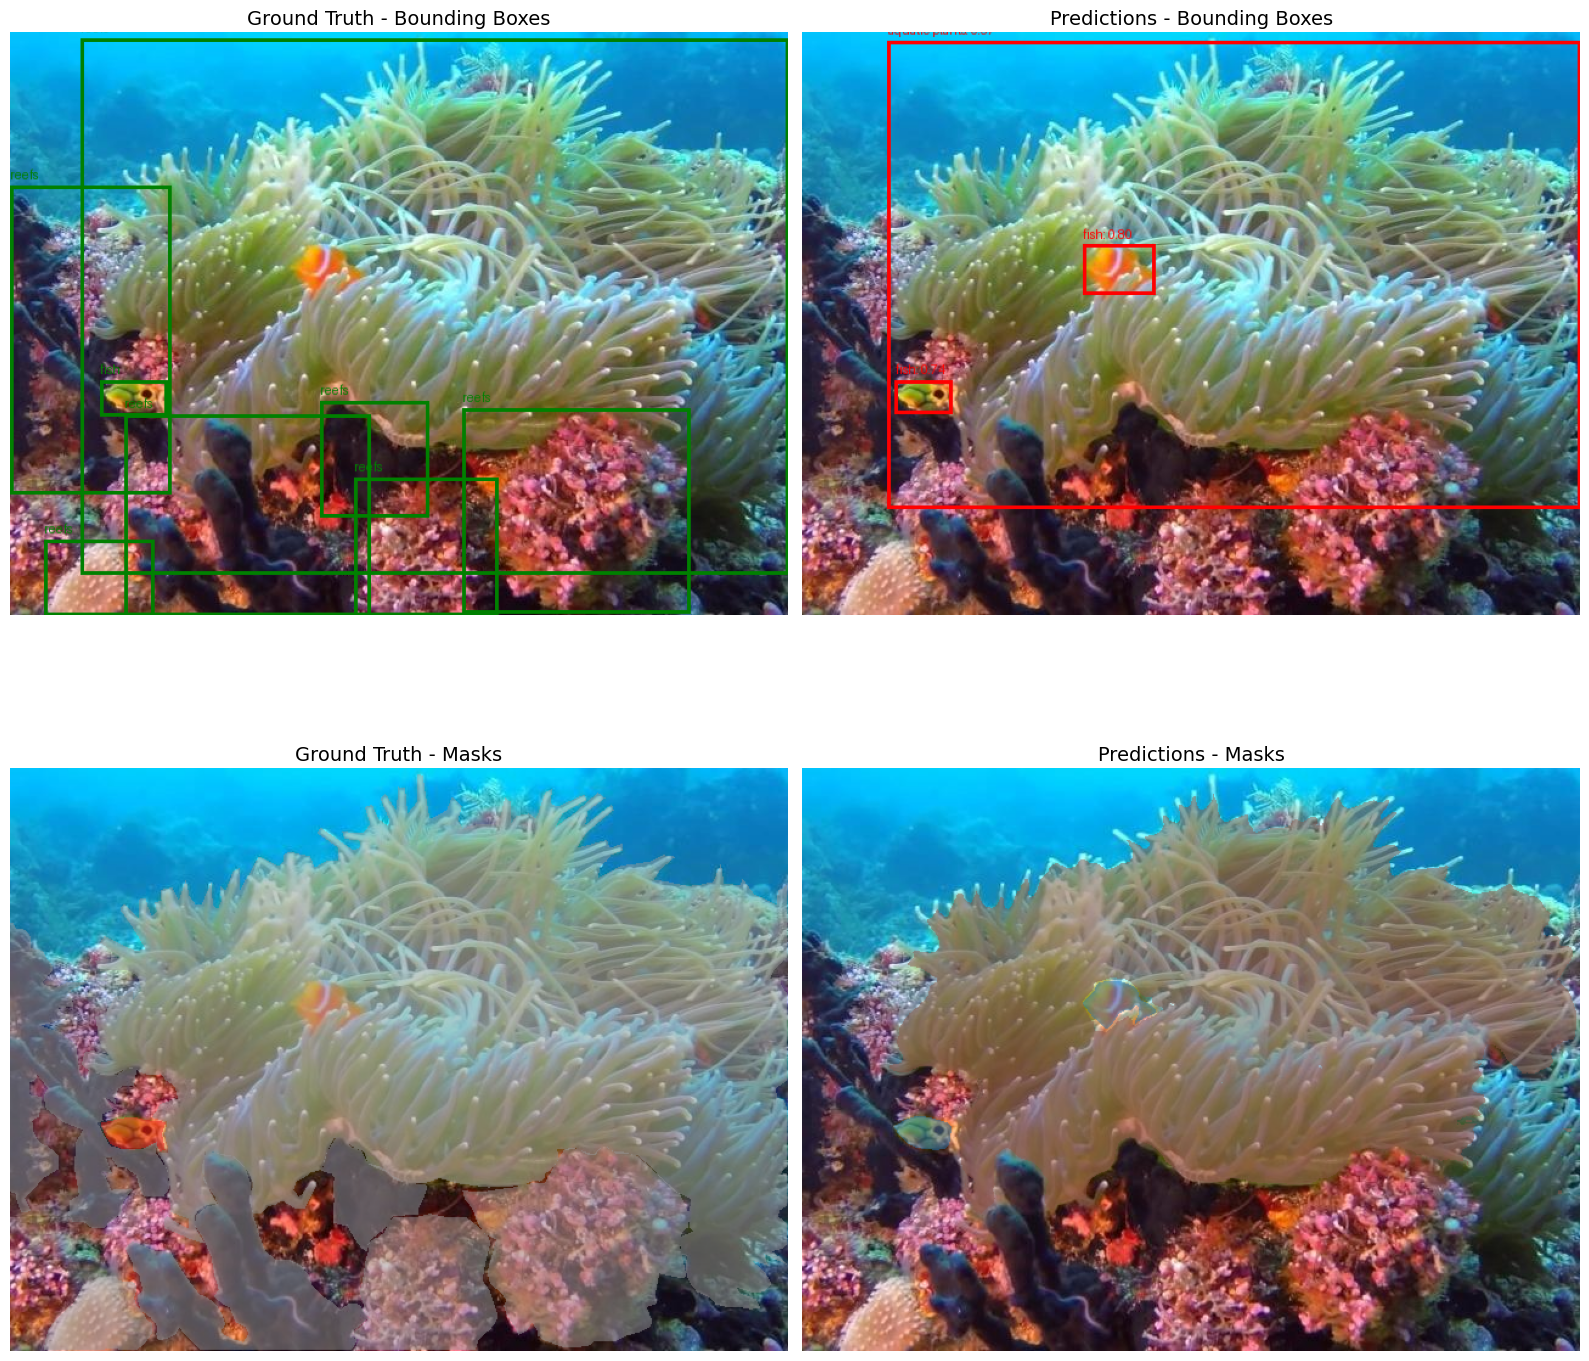


Legend:
  Ground Truth categories: {'fish': 'RGB(228, 26, 28)', 'reefs': 'RGB(153, 153, 153)'}
  Prediction prompts: {'fish': 'RGB(31, 119, 180)', 'wrecks/ruins': 'RGB(255, 127, 14)', 'reefs': 'RGB(214, 39, 40)', 'aquatic plants': 'RGB(140, 86, 75)', 'human divers': 'RGB(227, 119, 194)', 'robots': 'RGB(188, 189, 34)', 'sea-floor': 'RGB(23, 190, 207)'}


In [48]:
# Visualize sample predictions vs ground truth (boxes + masks)
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from pycocotools import mask as mask_utils

gt_data = json.load(open('USIS10K\\multi_class_annotations\\multi_class_test_annotations.json'))

filename_to_id = {img['file_name']: img['id'] for img in gt_data['images']}
id_to_size = {img['id']: (img['height'], img['width']) for img in gt_data['images']}

def visualize_comparison(img_path, pred, gt_annotations, cat_names, id_to_size, filename_to_id):
    """Visualize predictions vs ground truth on an image, including masks."""
    img = Image.open(img_path)
    filename = img_path.split('/')[-1]
    image_id = filename_to_id.get(filename)
    height, width = id_to_size[image_id] if image_id else (img.height, img.width)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    
    # ===================== ROW 1: BOUNDING BOXES =====================
    # Ground truth boxes
    ax1 = axes[0, 0]
    img_gt = img.copy()
    draw = ImageDraw.Draw(img_gt)
    for ann in gt_annotations:
        bbox = ann['bbox']  # [x, y, w, h]
        x, y, w, h = bbox
        cat_name = cat_names.get(ann['category_id'], str(ann['category_id']))
        draw.rectangle([x, y, x+w, y+h], outline='green', width=3)
        draw.text((x, y-15), cat_name, fill='green')
    ax1.imshow(img_gt)
    ax1.set_title('Ground Truth - Bounding Boxes', fontsize=14)
    ax1.axis('off')
    
    # Predictions boxes
    ax2 = axes[0, 1]
    img_pred = img.copy()
    draw = ImageDraw.Draw(img_pred)
    for prompt, preds in pred.items():
        if prompt == 'img_path':
            continue
        boxes = preds.get('boxes', [])
        scores = preds.get('scores', [])
        for box, score in zip(boxes, scores):
            x1, y1, x2, y2 = box
            draw.rectangle([x1, y1, x2, y2], outline='red', width=3)
            draw.text((x1, y1-15), f"{prompt}: {score:.2f}", fill='red')
    ax2.imshow(img_pred)
    ax2.set_title('Predictions - Bounding Boxes', fontsize=14)
    ax2.axis('off')
    
    # ===================== ROW 2: MASKS =====================
    # Ground truth masks
    ax3 = axes[1, 0]
    img_gt_mask = img.copy().convert("RGBA")
    
    # Create colormap for GT categories
    gt_categories = list(set(ann['category_id'] for ann in gt_annotations))
    cmap_gt = matplotlib.colormaps.get_cmap("Set1").resampled(max(len(gt_categories), 1))
    cat_to_color = {cat_id: tuple(int(c * 255) for c in cmap_gt(i)[:3]) for i, cat_id in enumerate(gt_categories)}
    
    for ann in gt_annotations:
        segm = ann['segmentation']
        cat_id = ann['category_id']
        color = cat_to_color.get(cat_id, (0, 255, 0))
        
        # Convert polygon to RLE then to binary mask
        try:
            rles = mask_utils.frPyObjects(segm, height, width)
            rle = mask_utils.merge(rles)
            mask_binary = mask_utils.decode(rle)
            
            # Create overlay
            mask_img = Image.fromarray((mask_binary * 255).astype(np.uint8))
            if mask_img.size != img_gt_mask.size:
                mask_img = mask_img.resize(img_gt_mask.size, Image.NEAREST)
            
            overlay = Image.new("RGBA", img_gt_mask.size, color + (0,))
            alpha = mask_img.point(lambda v: int(v * 0.5))  # 50% transparency
            overlay.putalpha(alpha)
            img_gt_mask = Image.alpha_composite(img_gt_mask, overlay)
        except Exception as e:
            pass
    
    ax3.imshow(img_gt_mask)
    ax3.set_title('Ground Truth - Masks', fontsize=14)
    ax3.axis('off')
    
    # Predictions masks
    ax4 = axes[1, 1]
    img_pred_mask = img.copy().convert("RGBA")
    
    # Get all prompts for colormap
    prompts = [p for p in pred.keys() if p != 'img_path']
    cmap_pred = matplotlib.colormaps.get_cmap("tab10").resampled(max(len(prompts), 1))
    prompt_to_color = {prompt: tuple(int(c * 255) for c in cmap_pred(i)[:3]) for i, prompt in enumerate(prompts)}
    
    for prompt, preds in pred.items():
        if prompt == 'img_path':
            continue
        
        masks_rle = preds.get('masks_rle', [])
        scores = preds.get('scores', [])
        color = prompt_to_color.get(prompt, (255, 0, 0))
        
        for i, rle in enumerate(masks_rle):
            if not rle:
                continue
            try:
                # Decode RLE mask
                if isinstance(rle['counts'], str):
                    rle_copy = {'size': rle['size'], 'counts': rle['counts'].encode('utf-8')}
                else:
                    rle_copy = rle
                mask_binary = mask_utils.decode(rle_copy)
                
                # Create overlay
                mask_img = Image.fromarray((mask_binary * 255).astype(np.uint8))
                if mask_img.size != img_pred_mask.size:
                    mask_img = mask_img.resize(img_pred_mask.size, Image.NEAREST)
                
                overlay = Image.new("RGBA", img_pred_mask.size, color + (0,))
                alpha = mask_img.point(lambda v: int(v * 0.5))  # 50% transparency
                overlay.putalpha(alpha)
                img_pred_mask = Image.alpha_composite(img_pred_mask, overlay)
            except Exception as e:
                pass
    
    ax4.imshow(img_pred_mask)
    ax4.set_title('Predictions - Masks', fontsize=14)
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print legend
    print("\nLegend:")
    print("  Ground Truth categories:", {cat_names.get(c, c): f"RGB{cat_to_color[c]}" for c in gt_categories})
    print("  Prediction prompts:", {p: f"RGB{prompt_to_color[p]}" for p in prompts})

# Visualize sample
sample_pred = predictions[1100]
sample_img_path = sample_pred['img_path']
sample_filename = sample_img_path.split('/')[-1]
sample_img_id = filename_to_id.get(sample_filename)
sample_gt = [ann for ann in gt_data['annotations'] if ann['image_id'] == sample_img_id]

visualize_comparison(sample_img_path, sample_pred, sample_gt, CATEGORY_TO_PROMPT, id_to_size, filename_to_id)